# Batches analysis 

In [1]:
#set up code
import sys
sys.path.append('../ProLib')
from ProteomicsUtility import utilities as PTUT
import ProtRank
import warnings
warnings.filterwarnings("ignore")
#define helphttp://localhost:8888/notebooks/calvin/new_data/analysis_427_2018.ipynb#ing function
import os
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text
from matplotlib.lines import Line2D
from Bio import SeqIO
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
plt.style.use('ggplot')

In [2]:
%load_ext rpy2.ipython
%matplotlib inline

# Load firsth batch

In [3]:
fname = '20210618_112159_115_2021_DUN_DH_TbruceiTREU927_added_BES_GFP-BLA_Report_protein_mw_peptides.txt.zip'
df_name = 'DIA_20210618/'+fname
df = pd.read_csv(df_name,sep='\t')
IsSingleHit = df[[n for n in df.columns if 'IsSingleHit' in n]]
IsSingleHit = IsSingleHit.replace({'FALSE':0,'TRUE':1,'Filtered':1})
filter_single = IsSingleHit.sum(axis=1)==0

#cols = ['64P']*3+['64M']*3+['84P']*3+['84M']*3+['87P']*3+['87M']*3+['GFP']*3
cols = (['64P1','64P2','64P3'] + 
        ['64M1','64M2','64M3']+ 
        ['84P1','84P2','84P3']+
        ['84M1','84M2','84M3']+
        ['87P1','87P2','87P3']+
        ['87M1','87M2','87M3']+
        ['GFP1','GFP2','GFP3'])
selection = df[[n for n in df.columns if 'PG.Quantity' in n]]
selection = selection[filter_single]
selection.columns = cols
selection = selection.astype(float)
print(selection.shape)
selection.head()

(4768, 21)


,64P1,64P2,64P3,64M1,64M2,64M3,84P1,84P2,84P3,84M1,...,84M3,87P1,87P2,87P3,87M1,87M2,87M3,GFP1,GFP2,GFP3
0,6.625102e+05,7.071590e+05,6.460579e+05,1.109581e+06,9.441736e+05,8.561842e+05,7.203922e+05,6.876621e+05,6.954382e+05,7.599050e+05,...,6.573732e+05,7.466480e+06,7.573164e+06,7.482479e+06,1.005414e+06,9.456432e+05,9.963870e+05,1.144193e+06,1.349816e+06,1.347236e+06
1,1.146910e+05,1.284831e+05,1.110746e+05,1.674055e+05,1.513609e+05,1.620779e+05,1.110987e+05,1.261317e+05,1.299924e+05,1.800457e+05,...,1.743339e+05,1.458583e+05,1.535586e+05,1.400646e+05,1.699370e+05,1.715979e+05,1.686144e+05,1.187170e+05,1.221337e+05,1.512330e+05
2,1.563449e+06,1.852021e+06,1.866614e+06,2.357439e+06,1.907906e+06,2.255454e+06,1.860188e+06,1.896992e+06,1.901786e+06,1.899312e+06,...,1.346840e+06,1.762202e+06,1.338600e+06,1.379844e+06,2.272458e+06,2.803822e+06,2.095319e+06,1.779644e+06,2.171076e+06,2.023830e+06
3,1.869629e+05,1.870117e+05,2.172645e+05,2.477764e+05,2.719160e+05,2.615199e+05,2.084145e+05,2.032012e+05,2.102419e+05,2.770011e+05,...,2.845097e+05,2.867445e+05,2.779016e+05,3.105260e+05,2.964359e+05,3.120681e+05,2.896445e+05,2.603491e+05,2.575734e+05,2.743419e+05
4,2.001409e+06,1.629075e+06,2.143744e+06,2.536182e+06,2.642000e+06,2.539547e+06,2.174133e+06,2.103496e+06,2.105590e+06,2.529122e+06,...,2.632349e+06,2.750689e+06,2.776378e+06,2.493743e+06,2.616211e+06,2.580914e+06,2.705292e+06,2.877781e+06,2.666046e+06,2.983822e+06


In [4]:
print(selection.shape)
batch_1 = selection.join(df[['PG.ProteinAccessions']],how='left')

(4768, 21)


# Load Second Batch

In [5]:
df_name = 'RBPs 2nd batch 927/Report_Protein_mw_peptides (Pivot).txt.zip'
df = pd.read_csv(df_name,sep='\t')
IsSingleHit = df[[n for n in df.columns if 'IsSingleHit' in n]]
IsSingleHit = IsSingleHit.replace({'FALSE':0,'TRUE':1,'Filtered':1})
filter_single = IsSingleHit.sum(axis=1)==0

In [6]:
cols = (['[1] GBR-1-46+1.raw.PG.Quantity',
         '[2] GBR-1-46+2.raw.PG.Quantity',
         '[3] GBR-1-46+3.raw.PG.Quantity']+ 
        ['[4] GBR-1-46-1.raw.PG.Quantity',
         '[5] GBR-1-46-2.raw.PG.Quantity',
         '[6] GBR-1-46-3.raw.PG.Quantity']+ 
        
        ['[7] GBR-6-25+1.raw.PG.Quantity',
         '[8] GBR-6-25+2.raw.PG.Quantity',
         '[9] GBR-6-25+3.raw.PG.Quantity']+
        ['[10] GBR-6-25-1.raw.PG.Quantity',
         '[11] GBR-6-25-2.raw.PG.Quantity',
         '[12] GBR-6-25-3.raw.PG.Quantity']+
        
        ['[13] GBR-6-44+1.raw.PG.Quantity',
         '[41] GBR-644+2.raw.PG.Quantity',
         '[14] GBR-6-44+3.raw.PG.Quantity']+
        ['[15] GBR-6-44-1.raw.PG.Quantity',
         '[42] GBR-644-2.raw.PG.Quantity',
         '[16] GBR-6-44-3.raw.PG.Quantity']+
        
        ['[17] GBR-8-27+1.raw.PG.Quantity',
         '[18] GBR-8-27+2.raw.PG.Quantity',
         '[19] GBR-8-27+3.raw.PG.Quantity']+
        ['[20] GBR-8-27-1.raw.PG.Quantity',
         '[21] GBR-8-27-2.raw.PG.Quantity',
         '[22] GBR-8-27-3.raw.PG.Quantity']+

        ['[23] GBR-9-87+1.raw.PG.Quantity',
         '[24] GBR-9-87+2.raw.PG.Quantity',
         '[25] GBR-9-87+3.raw.PG.Quantity']+
        ['[26] GBR-9-87-1.raw.PG.Quantity',
         '[27] GBR-9-87-2.raw.PG.Quantity',
         '[28] GBR-9-87-3.raw.PG.Quantity']+

        ['[29] GBR-10-54+1.raw.PG.Quantity',
         '[30] GBR-10-54+2.raw.PG.Quantity',
         '[31] GBR-10-54+3.raw.PG.Quantity']+
        ['[32] GBR-10-54-1.raw.PG.Quantity',
         '[33] GBR-10-54-2-rpt.raw.PG.Quantity',
         '[34] GBR-10-54-3-rpt.raw.PG.Quantity']+        

        ['[35] GBR-11-4+1.raw.PG.Quantity',
         '[36] GBR-11-4+2.raw.PG.Quantity',
         '[37] GBR-11-4+3.raw.PG.Quantity']+
        ['[38] GBR-11-4-1-repeat.raw.PG.Quantity',
         '[39] GBR-11-4-2.raw.PG.Quantity',
         '[40] GBR-11-4-3.raw.PG.Quantity']+        

        
        ['[43] GBR-Rep-1.raw.PG.Quantity',
         '[44] GBR-Rep-2.raw.PG.Quantity',
         '[45] GBR-Rep-3.raw.PG.Quantity'])

selection = df[cols]
print(selection.shape)
selection = selection[filter_single]
print(selection.shape)

new_cols = [
'P146-1','P146-2','P146-3',
'M146-1','M146-2','M146-3',

'P625-1','P625-2','P625-3',
'M625-1','M625-2','M625-3',

'P644-1','P644-2','P644-3',
'M644-1','M644-2','M644-3',
    
'P827-1','P827-2','P827-3',
'M827-1','M827-2','M827-3',
    
'P987-1','P987-2','P987-3',
'M987-1','M987-2','M987-3',
    
'P1054-1','P1054-2','P1054-3',
'M1054-1','M1054-2','M1054-3',    
    
'P114-1','P114-2','P114-3',
'M114-1','M114-2','M114-3', 
    
'GFPB-1','GFPB-2','GFPB-3', 
]
selection.columns = new_cols
selection.head()

for col in selection.columns:
    selection[col]=selection[col].astype(float)

(5491, 45)
(4727, 45)


In [7]:
print(selection.shape)
batch_2 = selection.join(df[['PG.ProteinAccessions']],how='left')
print(batch_2.shape)

(4727, 45)
(4727, 46)


In [8]:
batch_2.set_index('PG.ProteinAccessions',inplace=True)
batch_1.set_index('PG.ProteinAccessions',inplace=True)

# Merge datasets

In [9]:
merge_batch = batch_1.join(batch_2,how='inner')
merge_batch.shape

(4402, 66)

In [10]:
merge_batch.head()

,64P1,64P2,64P3,64M1,64M2,64M3,84P1,84P2,84P3,84M1,...,M1054-3,P114-1,P114-2,P114-3,M114-1,M114-2,M114-3,GFPB-1,GFPB-2,GFPB-3
PG.ProteinAccessions,,,,,,,,,,,,,,,,,,,,,
GFP.BLA,6.625102e+05,7.071590e+05,6.460579e+05,1.109581e+06,9.441736e+05,8.561842e+05,7.203922e+05,6.876621e+05,6.954382e+05,7.599050e+05,...,2.642244e+06,2.722660e+06,2.736450e+06,2.952524e+06,2.323748e+06,2.639608e+06,2457415.000,2.819019e+06,2.944748e+06,2795521.250
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,1.146910e+05,1.284831e+05,1.110746e+05,1.674055e+05,1.513609e+05,1.620779e+05,1.110987e+05,1.261317e+05,1.299924e+05,1.800457e+05,...,2.565752e+05,2.053362e+05,2.667651e+05,2.095507e+05,2.910576e+05,2.464055e+05,273542.125,2.918621e+05,2.626969e+05,262475.625
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,1.563449e+06,1.852021e+06,1.866614e+06,2.357439e+06,1.907906e+06,2.255454e+06,1.860188e+06,1.896992e+06,1.901786e+06,1.899312e+06,...,1.673078e+06,1.629132e+06,1.677594e+06,1.748376e+06,1.588898e+06,1.631590e+06,1665623.625,1.685135e+06,1.630652e+06,1829206.750
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,1.869629e+05,1.870117e+05,2.172645e+05,2.477764e+05,2.719160e+05,2.615199e+05,2.084145e+05,2.032012e+05,2.102419e+05,2.770011e+05,...,3.951536e+05,4.230911e+05,3.762118e+05,4.064929e+05,3.262426e+05,3.910819e+05,381422.875,3.736802e+05,3.853037e+05,387422.125
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,2.001409e+06,1.629075e+06,2.143744e+06,2.536182e+06,2.642000e+06,2.539547e+06,2.174133e+06,2.103496e+06,2.105590e+06,2.529122e+06,...,1.910456e+06,2.078076e+06,2.138294e+06,2.345841e+06,2.083957e+06,1.397410e+06,2143545.250,2.160984e+06,2.056663e+06,1634870.625


In [11]:
palette=['r','r','r','r','r','r']*3+['r']*3+['g','g','g','g','g','g']*7+['g']*3
palette_g = ['r','g']
color_dictionary = {'r':'batch1','g':'batch2'}
!mkdir -p merge_plot
OUT_FOLDER='merge_plot'

# KDE plot

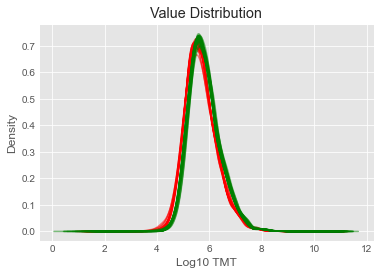

In [12]:
np.log10(merge_batch).plot(kind='kde', color=palette, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Value Distribution')
plt.xlabel('Log10 TMT')
plt.savefig(os.path.join(OUT_FOLDER,'3_value_distribution_kde.png'))
plt.legend('')
plt.show()

In [13]:
#np.log10(merge_batch).mean().plot()

# Box plot

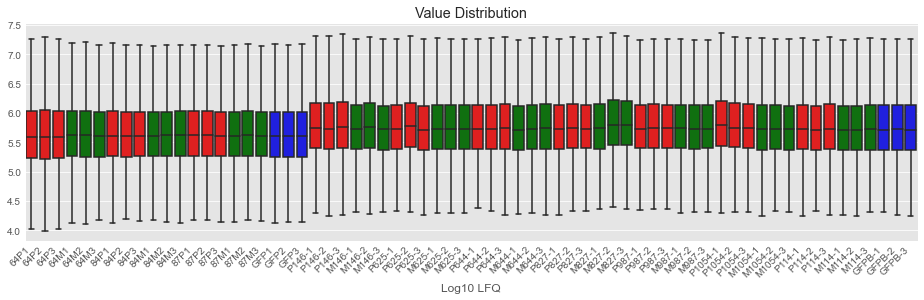

In [14]:
palette=['r','r','r','g','g','g']*3+['b']*3+['r','r','r','g','g','g']*7+['b']*3
palette_g = ['r','g','b']
color_dictionary = {'r':'Plus','g':'Minus','b':'GFP'}

fig,ax=plt.subplots(figsize=(16,4))
sns.boxplot(data = np.log10(merge_batch), showfliers=False, palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'4_value_distribution_box.png'))
plt.show()

# MDS pre norm

{'r': 'Plus', 'g': 'Minus', 'b': 'GFP'}


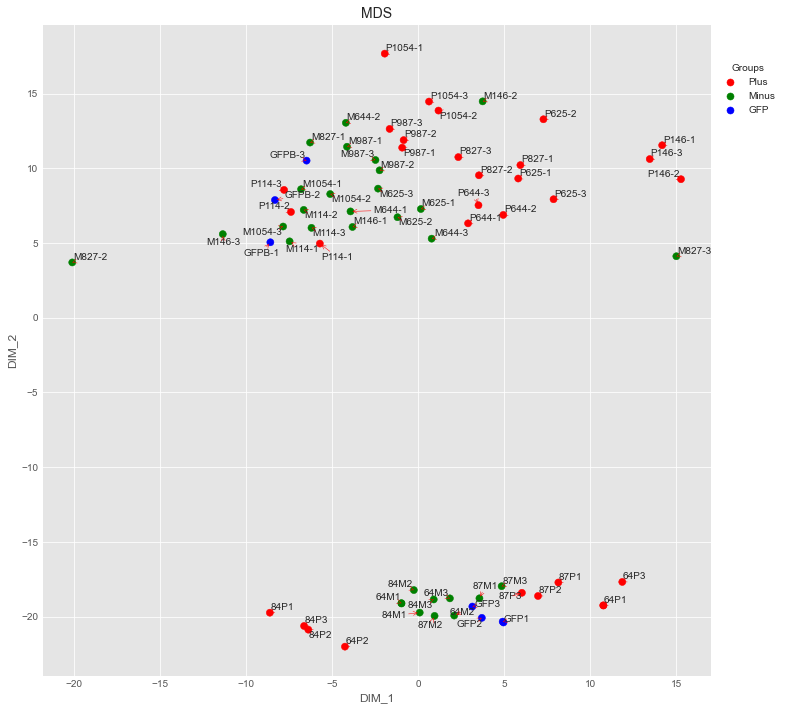

In [15]:
fig, ax = plt.subplots(figsize=(12,12))

ax = PTUT.make_mds(np.log2(merge_batch), palette, ax, top=500,
                   color_dictionary=color_dictionary)
plt.savefig(os.path.join(OUT_FOLDER,'5_mds.png')) 



# Median Equalize Norm

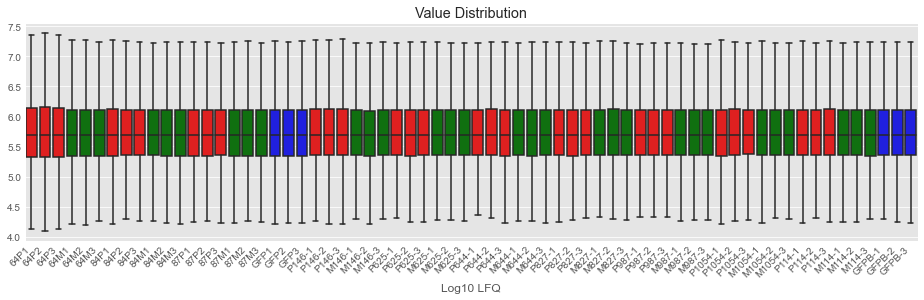

In [16]:
#https://codereview.stackexchange.com/questions/25417/is-there-a-better-way-to-make-a-function-silent-on-need
class NoStdStreams(object):
    def __init__(self, stdout = None, stderr = None):
        self.devnull = open(os.devnull,'w')
        self._stdout = stdout or self.devnull or sys.stdout
        self._stderr = stderr or self.devnull or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()

with NoStdStreams():
   selection_normed = PTUT.norm_loading(merge_batch)

fig, ax = plt.subplots(figsize=(16,4))
sns.boxplot(data =np.log10(selection_normed),showfliers=False,palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'6_value_distribution_box.png'))
plt.show()

# MDS after median equalize

{'r': 'Plus', 'g': 'Minus', 'b': 'GFP'}


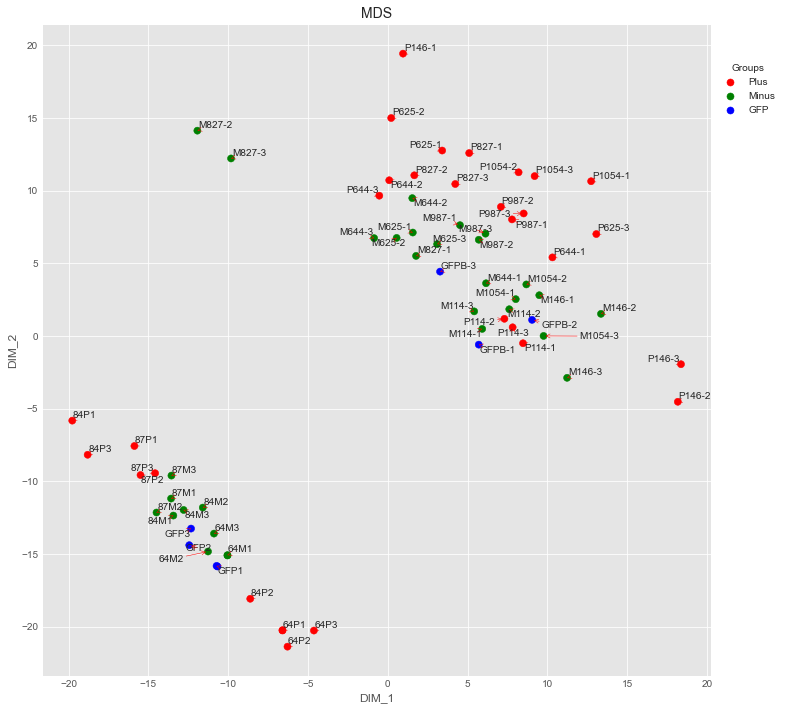

In [17]:
fig, ax = plt.subplots(figsize=(12,12))

ax = PTUT.make_mds(np.log2(selection_normed), palette, ax, top=500,
                   color_dictionary=color_dictionary)
plt.savefig(os.path.join(OUT_FOLDER,'7_mds.png')) 

In [18]:
#fig, ax = plt.subplots(figsize=(16,14))
#sns.heatmap(np.log2(selection_normed).corr(),ax=ax)

# Quantile Norm

In [19]:
selection_normed2 = PTUT.quantileNormalize(merge_batch)

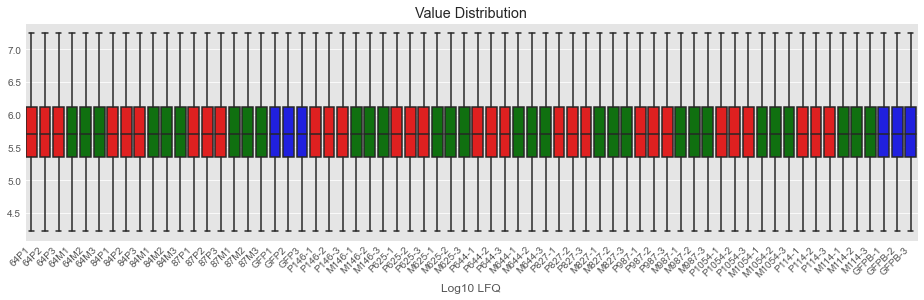

In [20]:
fig, ax = plt.subplots(figsize=(16,4))
sns.boxplot(data =np.log10(selection_normed2),showfliers=False,palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'9_value_distribution_box.png'))
plt.show()

# MDS after quantile norm

{'r': 'Plus', 'g': 'Minus', 'b': 'GFP'}


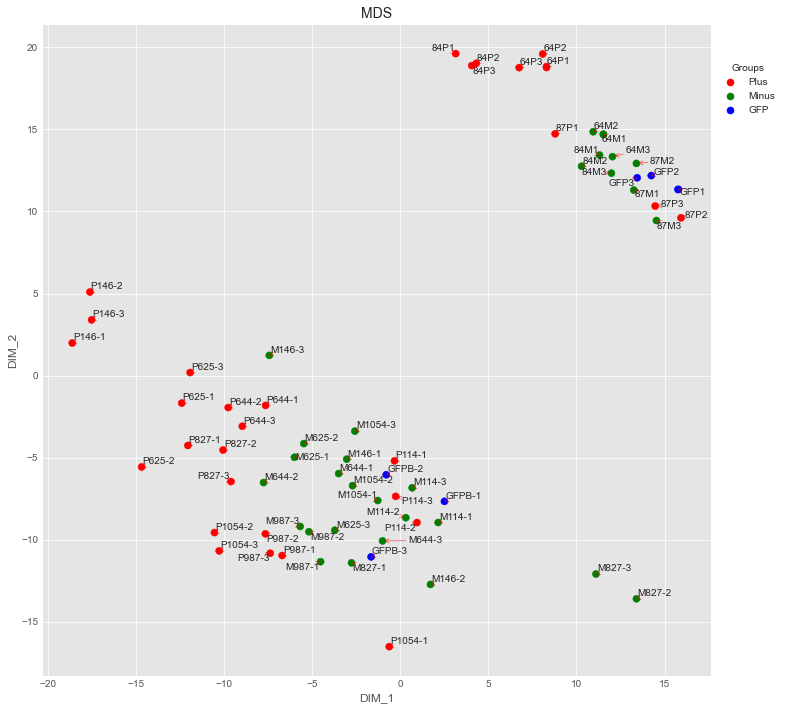

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
ax = PTUT.make_mds(np.log2(selection_normed2), palette, ax, top=500,
                   color_dictionary=color_dictionary)
plt.savefig(os.path.join(OUT_FOLDER,'10_mds.png')) 

# Remove batch effect

In [22]:
%%R
library(sva)
library(limma)
library(HybridMTest)

In [23]:
%R c(rep(1, 7*3),rep(2, 15*3))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [24]:
#selection_normed_log.head()

In [25]:
selection_normed.head()

,64P1,64P2,64P3,64M1,64M2,64M3,84P1,84P2,84P3,84M1,...,M1054-3,P114-1,P114-2,P114-3,M114-1,M114-2,M114-3,GFPB-1,GFPB-2,GFPB-3
PG.ProteinAccessions,,,,,,,,,,,,,,,,,,,,,
GFP.BLA,8.449231e+05,8.948600e+05,8.263305e+05,1.312187e+06,1.138776e+06,1.052105e+06,8.825008e+05,8.654323e+05,8.699929e+05,9.260862e+05,...,2.522609e+06,2.570709e+06,2.637190e+06,2.789235e+06,2.241298e+06,2.567636e+06,2.321510e+06,2.724196e+06,2.821844e+06,2.694839e+06
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,1.462695e+05,1.625863e+05,1.420683e+05,1.979732e+05,1.825578e+05,1.991662e+05,1.360990e+05,1.587385e+05,1.626204e+05,2.194194e+05,...,2.449581e+05,1.938764e+05,2.570887e+05,1.979614e+05,2.807304e+05,2.396869e+05,2.584142e+05,2.820447e+05,2.517328e+05,2.530224e+05
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,1.993922e+06,2.343602e+06,2.387464e+06,2.787900e+06,2.301142e+06,2.771570e+06,2.278783e+06,2.387392e+06,2.379133e+06,2.314666e+06,...,1.597325e+06,1.538211e+06,1.616743e+06,1.651682e+06,1.532521e+06,1.587103e+06,1.573508e+06,1.628452e+06,1.562594e+06,1.763327e+06
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,2.384405e+05,2.366502e+05,2.778889e+05,2.930195e+05,3.279603e+05,3.213635e+05,2.553136e+05,2.557315e+05,2.630125e+05,3.375776e+05,...,3.772620e+05,3.994785e+05,3.625654e+05,3.840117e+05,3.146670e+05,3.804185e+05,3.603287e+05,3.611108e+05,3.692224e+05,3.734689e+05
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,2.552469e+06,2.061480e+06,2.741922e+06,2.999280e+06,3.186540e+06,3.120672e+06,2.663374e+06,2.647278e+06,2.634092e+06,3.082208e+06,...,1.823955e+06,1.962099e+06,2.060732e+06,2.216104e+06,2.010015e+06,1.359308e+06,2.024999e+06,2.088296e+06,1.970825e+06,1.575990e+06


In [26]:
selection_normed_log = np.log2(selection_normed)
selection_normed_log.head()

,64P1,64P2,64P3,64M1,64M2,64M3,84P1,84P2,84P3,84M1,...,M1054-3,P114-1,P114-2,P114-3,M114-1,M114-2,M114-3,GFPB-1,GFPB-2,GFPB-3
PG.ProteinAccessions,,,,,,,,,,,,,,,,,,,,,
GFP.BLA,19.688460,19.771302,19.656359,20.323542,20.119053,20.004847,19.751238,19.723061,19.730644,19.820787,...,21.266485,21.293735,21.330570,21.411438,21.095903,21.292009,21.146632,21.377399,21.428207,21.361768
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,17.158270,17.310846,17.116225,17.594946,17.477994,17.603613,17.054297,17.276292,17.311148,17.743331,...,17.902175,17.564778,17.971907,17.594860,18.098826,17.870792,17.979326,18.105564,17.941534,17.948906
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,20.927178,21.160296,21.187047,21.410747,21.133918,21.402272,21.119832,21.187004,21.182004,21.142373,...,20.607227,20.552822,20.624659,20.655505,20.547476,20.597964,20.585553,20.635070,20.575512,20.749869
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,17.863270,17.852397,18.084149,18.160637,18.323162,18.293847,17.961911,17.964270,18.004772,18.364860,...,18.525207,18.607758,18.467882,18.550791,18.263466,18.537228,18.458954,18.462082,18.494131,18.510629
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,21.283462,20.975249,21.386756,21.516185,21.603559,21.573425,21.344824,21.336079,21.328874,21.555533,...,20.798639,20.903967,20.974725,21.079594,20.938775,20.374441,20.949490,20.993895,20.910368,20.587827


## Using ComBat

In [27]:
%%R -i selection_normed_log

f<- factor(c(rep("P64",3),rep("M64",3),rep("P84",3),rep("M84",3),
             rep("P87",3),rep("M87",3),rep("GFP",3),
             
             rep("P146",3),rep("M146",3),rep("P625",3),rep("M625",3),
             rep("P644",3),rep("M644",3),rep("P827",3),rep("M827",3),
             rep("P987",3),rep("M987",3),rep("P1054",3),rep("M1054",3),
             rep("P114",3),rep("M114",3),rep("GFP",3))
           
           ,levels=c("GFP", "P64", "M64", "P84", "M84", "P87", "M87",
                     "P146", "M146", "P625", "M625",
                     "P644", "M644", "P827", "M827",
                     "P987", "M987", "P1054", "M1054",
                     "P114", "M114"))

batch <- c(rep(1, 7*3), rep(2, 15*3))
mod <- model.matrix(~f)

#as.matrix(selection_normed_log)
#selection_normed_rb <- removeBatchEffect(selection_normed_log, batch=batch, design=mod)

selection_normed_rb2 <- ComBat(dat = as.matrix(selection_normed_log), batch = batch, mod = mod, par.prior = TRUE)
#head(selection_normed_rb)

Standardizing Data across genes


In [28]:
%R -o selection_normed_rb2

#selection_normed_rb
selection_normed_rb2 =  pd.DataFrame(np.reshape(selection_normed_rb2, (4402, 66)))
selection_normed_rb2.columns = selection_normed2.columns
selection_normed_rb2.index = selection_normed2.index
selection_normed_rb2.head()

,64P1,64P2,64P3,64M1,64M2,64M3,84P1,84P2,84P3,84M1,...,M1054-3,P114-1,P114-2,P114-3,M114-1,M114-2,M114-3,GFPB-1,GFPB-2,GFPB-3
PG.ProteinAccessions,,,,,,,,,,,,,,,,,,,,,
GFP.BLA,20.241973,20.353116,20.198905,20.942410,20.668062,20.514841,20.316082,20.278280,20.288453,20.418568,...,21.005104,21.038451,21.071983,21.145599,20.843378,21.021898,20.889558,21.118547,21.164798,21.104317
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,17.606736,17.955774,17.510554,18.137330,17.869787,18.157158,17.344679,17.852522,17.932260,18.272201,...,17.688166,17.353580,17.707576,17.379736,17.853490,17.655215,17.749585,17.861396,17.718772,17.725182
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,20.609229,20.763187,20.780855,21.004703,20.821878,20.999106,20.760723,20.805085,20.801783,20.740129,...,20.777180,20.713331,20.802213,20.840379,20.714783,20.777252,20.761896,20.805014,20.731323,20.947052
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,17.928002,17.906500,18.364798,18.197436,18.518834,18.460862,18.080338,18.085004,18.165097,18.522442,...,18.456317,18.537804,18.415223,18.487880,18.220966,18.460877,18.392281,18.403563,18.431648,18.446106
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,20.730270,20.184969,20.913023,20.873369,21.027955,20.974641,20.745421,20.729948,20.717203,20.927022,...,21.078302,21.194828,21.257324,21.349947,21.198497,20.700060,21.207961,21.256109,21.182336,20.897458


## Using Limma

In [29]:
%%R -i selection_normed_log

f<- factor(c(rep("P64",3),rep("M64",3),rep("P84",3),rep("M84",3),
             rep("P87",3),rep("M87",3),rep("GFP",3),
             
             rep("P146",3),rep("M146",3),rep("P625",3),rep("M625",3),
             rep("P644",3),rep("M644",3),rep("P827",3),rep("M827",3),
             rep("P987",3),rep("M987",3),rep("P1054",3),rep("M1054",3),
             rep("P114",3),rep("M114",3),rep("GFP",3))
           
           ,levels=c("P64", "M64", "P84", "M84", "P87", "M87",
                     "GFP", "P146", "M146", "P625", "M625",
                     "P644", "M644", "P827", "M827",
                     "P987", "M987", "P1054", "M1054",
                     "P114", "M114"))



batch <- c(rep(1, 7*3), rep(2, 15*3))
mod <- model.matrix(~0+f)

#as.matrix(selection_normed_log)
selection_normed_rb <- removeBatchEffect(selection_normed_log, batch=batch, design=mod)

#selection_normed_rb <- ComBat(dat = as.matrix(selection_normed_log), batch = batch, mod = mod, par.prior = TRUE)
#head(selection_normed_rb)

In [30]:
%R -o selection_normed_rb
selection_normed_rb

20.099413,17.522347,20.651978,17.961046,...,20.526398,21.790574,18.101378,17.172225


In [31]:
%R -o selection_normed_rb
#selection_normed_rb
selection_normed_rb =  pd.DataFrame(np.reshape(selection_normed_rb, (4402, 66)))
selection_normed_rb.columns = selection_normed.columns
selection_normed_rb.index = selection_normed.index
selection_normed_rb.head()

,64P1,64P2,64P3,64M1,64M2,64M3,84P1,84P2,84P3,84M1,...,M1054-3,P114-1,P114-2,P114-3,M114-1,M114-2,M114-3,GFPB-1,GFPB-2,GFPB-3
PG.ProteinAccessions,,,,,,,,,,,,,,,,,,,,,
GFP.BLA,20.099413,20.182255,20.067312,20.734495,20.530005,20.415800,20.162191,20.134014,20.141597,20.231740,...,20.855533,20.882782,20.919618,21.000485,20.684951,20.881056,20.735680,20.966447,21.017254,20.950815
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,17.522347,17.674924,17.480303,17.959023,17.842071,17.967691,17.418375,17.640370,17.675226,18.107409,...,17.538098,17.200700,17.607829,17.230782,17.734748,17.506714,17.615248,17.741487,17.577456,17.584828
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,20.651978,20.885097,20.911848,21.135548,20.858719,21.127072,20.844632,20.911804,20.906805,20.867173,...,20.882426,20.828021,20.899858,20.930704,20.822675,20.873164,20.860753,20.910270,20.850711,21.025068
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,17.961046,17.950173,18.181925,18.258414,18.420938,18.391623,18.059687,18.062047,18.102548,18.462636,...,18.427431,18.509982,18.370105,18.453015,18.165690,18.439452,18.361178,18.364306,18.396354,18.412852
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,20.838580,20.530367,20.941874,21.071303,21.158677,21.128543,20.899942,20.891197,20.883993,21.110651,...,21.243521,21.348849,21.419607,21.524476,21.383657,20.819323,21.394371,21.438776,21.355250,21.032709


# MDS after removing batch effect

## with Limma

{'r': 'Plus', 'g': 'Minus', 'b': 'GFP'}


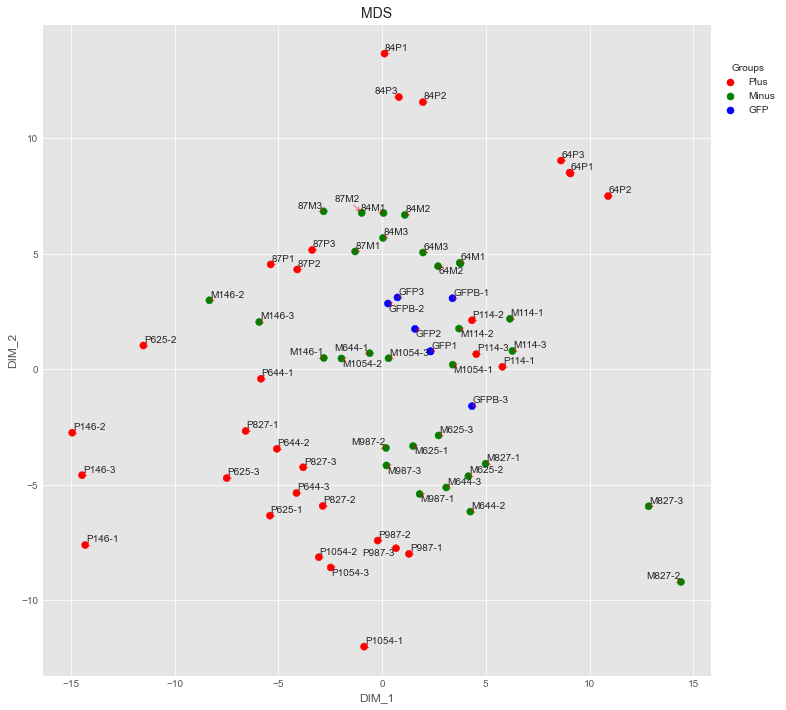

In [32]:
plt.style.use='ggplot'
fig, ax = plt.subplots(figsize=(12,12))
ax = PTUT.make_mds(selection_normed_rb, palette, ax, top=500,
                   color_dictionary=color_dictionary)
plt.savefig(os.path.join(OUT_FOLDER, '11_mds.png')) 

## With ComBat

{'r': 'Plus', 'g': 'Minus', 'b': 'GFP'}


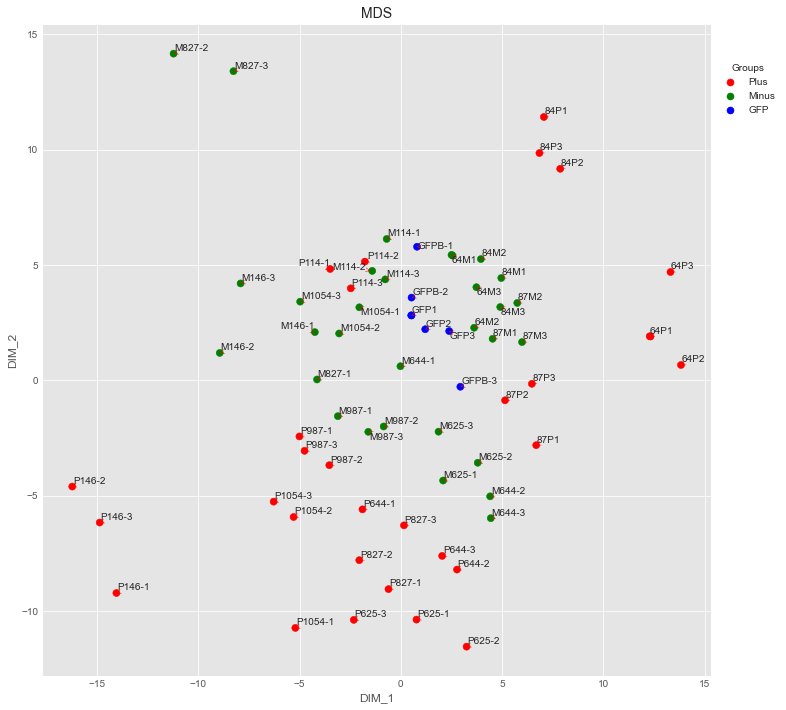

In [33]:
plt.style.use='ggplot'
fig, ax = plt.subplots(figsize=(12,12))
ax = PTUT.make_mds(selection_normed_rb2, palette, ax, top=500,
                   color_dictionary=color_dictionary)
plt.savefig(os.path.join(OUT_FOLDER, '12_mds.png')) 

In [34]:
#plt.style.use='ggplot'
#fig, ax = plt.subplots(figsize=(12,12))
#ax = PTUT.make_pca(selection_normed_rb, palette, ax, top=500,
#                   color_dictionary=color_dictionary,do_adjust_text=True)
#plt.savefig(os.path.join(OUT_FOLDER, '11_mds.png')) 

In [35]:
#fig, ax = plt.subplots(figsize=(16,14))
#sns.heatmap(selection_normed_rb.corr(),ax=ax)

# Coefficent of variation analysis

In [36]:
cv_set = []

In [37]:
temp = np.log2(merge_batch)[[n for n in merge_batch if 'GFP' in n]]
temp = temp.std(axis=1)/temp.mean(axis=1)
cv_set.append(temp)

In [38]:
temp = np.log2(selection_normed)[[n for n in selection_normed if 'GFP' in n]]
temp = temp.std(axis=1)/temp.mean(axis=1)
cv_set.append(temp)

In [39]:
temp = np.log2(selection_normed2)[[n for n in selection_normed2 if 'GFP' in n]]
temp = temp.std(axis=1)/temp.mean(axis=1)
cv_set.append(temp)

In [40]:
temp = selection_normed_rb[[n for n in selection_normed_rb if 'GFP' in n]]
temp = temp.std(axis=1)/temp.mean(axis=1)
cv_set.append(temp)

In [41]:
temp = selection_normed_rb2[[n for n in selection_normed_rb if 'GFP' in n]]
temp = temp.std(axis=1)/temp.mean(axis=1)
cv_set.append(temp)

In [42]:
cv_set = pd.concat(cv_set,axis=1)
cv_set.columns = ['start','norm_median','norm_quantile','no_batch_Limma','no_batch_ComBat']

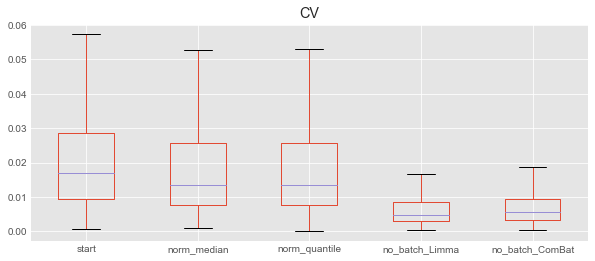

In [43]:
cv_set.plot(kind='box',showfliers=False,figsize=(10,4))
plt.title('CV')
plt.show()

# GFP exp correlations

## before removing batch effect

In [44]:
np.log2(selection_normed)[['GFP1','GFP2','GFP3','GFPB-1','GFPB-2','GFPB-3']].corr()

,GFP1,GFP2,GFP3,GFPB-1,GFPB-2,GFPB-3
GFP1,1.000000,0.988464,0.984483,0.862066,0.861402,0.862540
GFP2,0.988464,1.000000,0.988379,0.863491,0.861875,0.864249
GFP3,0.984483,0.988379,1.000000,0.865581,0.863728,0.866757
GFPB-1,0.862066,0.863491,0.865581,1.000000,0.983929,0.977378
GFPB-2,0.861402,0.861875,0.863728,0.983929,1.000000,0.981039
GFPB-3,0.862540,0.864249,0.866757,0.977378,0.981039,1.000000


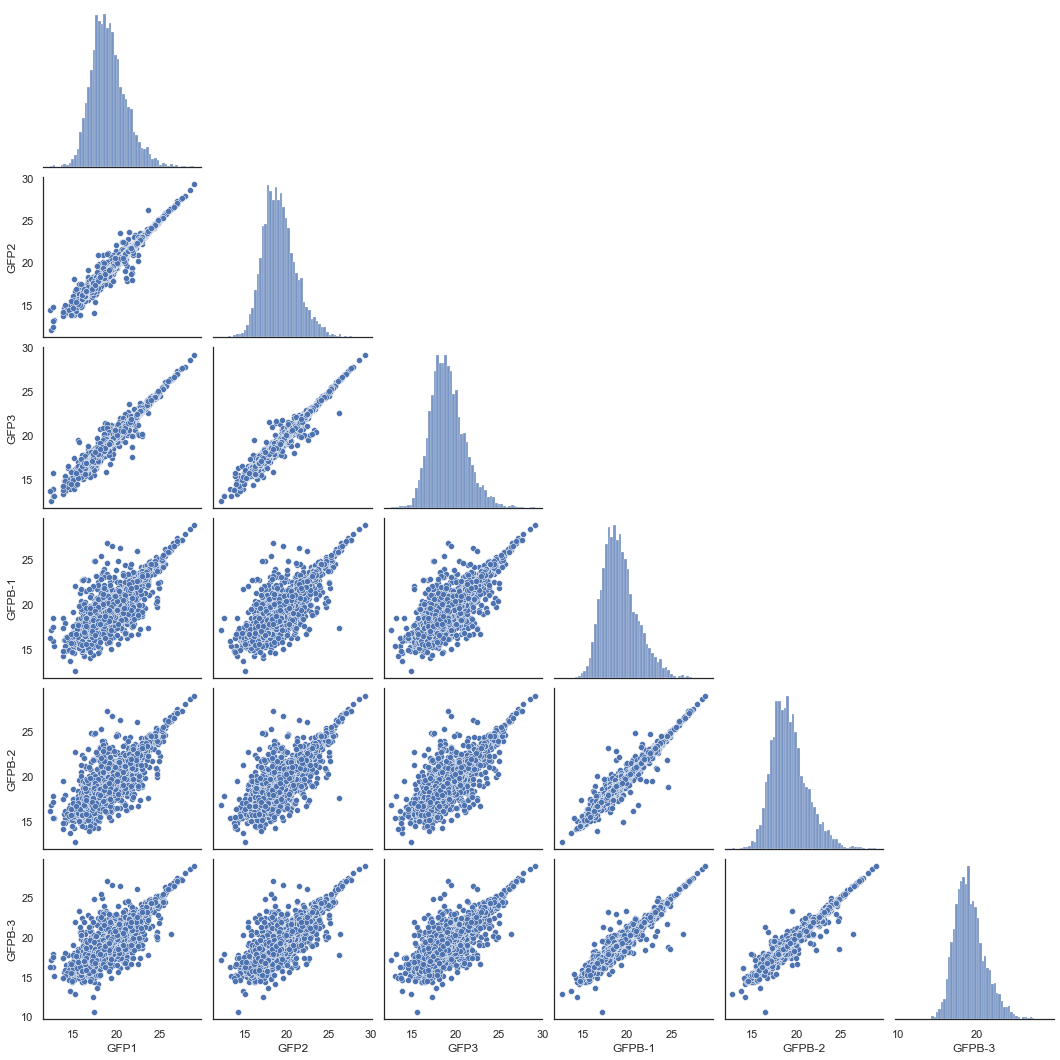

In [45]:
sns.set_theme(style="white")
sns.pairplot(np.log2(selection_normed[['GFP1','GFP2','GFP3',
                                  'GFPB-1','GFPB-2','GFPB-3']]), corner=True)



## after removing batch effect

In [46]:
selection_normed_rb[['GFP1','GFP2','GFP3','GFPB-1','GFPB-2','GFPB-3']].corr()

,GFP1,GFP2,GFP3,GFPB-1,GFPB-2,GFPB-3
GFP1,1.000000,0.987531,0.983234,0.987940,0.989961,0.986598
GFP2,0.987531,1.000000,0.987437,0.989566,0.990571,0.988523
GFP3,0.983234,0.987437,1.000000,0.988025,0.988786,0.987419
GFPB-1,0.987940,0.989566,0.988025,1.000000,0.983034,0.976167
GFPB-2,0.989961,0.990571,0.988786,0.983034,1.000000,0.980006
GFPB-3,0.986598,0.988523,0.987419,0.976167,0.980006,1.000000


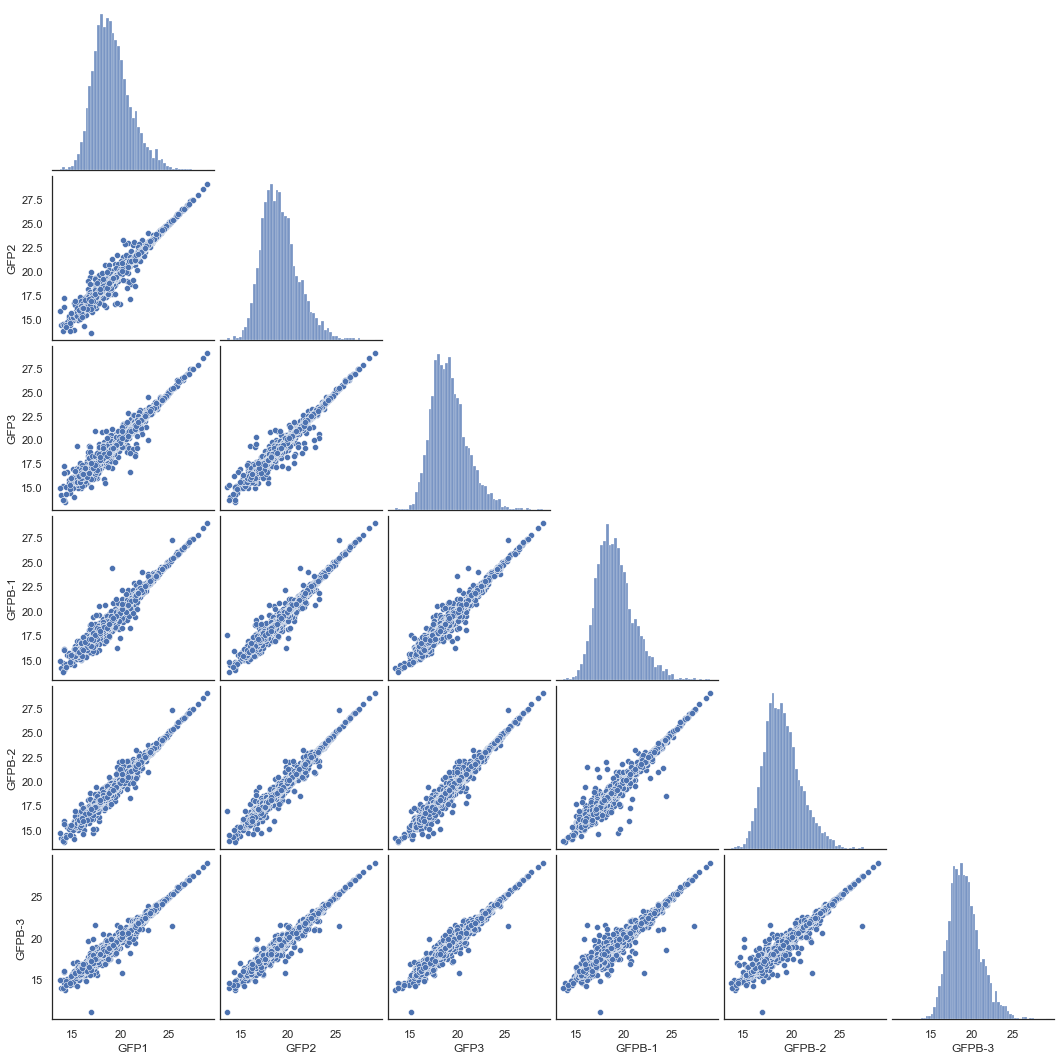

In [47]:
sns.set_theme(style="white")
sns.pairplot(selection_normed_rb[['GFP1','GFP2','GFP3',
                                  'GFPB-1','GFPB-2','GFPB-3']], corner=True)


# Cluster GFPs and Induced experiments

In [48]:
cols = [n for n in selection_normed_rb if 'GFP' in n]+[n for n in selection_normed_rb if 'P' in n]
ncols = []
for n in cols:
    if n not in ncols:
        ncols.append(n)

temp = selection_normed_rb[ncols]

In [49]:
temp.head()

,GFP1,GFP2,GFP3,GFPB-1,GFPB-2,GFPB-3,64P1,64P2,64P3,84P1,...,P827-3,P987-1,P987-2,P987-3,P1054-1,P1054-2,P1054-3,P114-1,P114-2,P114-3
PG.ProteinAccessions,,,,,,,,,,,,,,,,,,,,,
GFP.BLA,20.818838,21.057827,21.057851,20.966447,21.017254,20.950815,20.099413,20.182255,20.067312,20.162191,...,22.853872,20.574942,20.704326,20.597495,20.607474,20.670743,20.566828,20.882782,20.919618,21.000485
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,17.503230,17.544722,17.855818,17.741487,17.577456,17.584828,17.522347,17.674924,17.480303,17.418375,...,17.514091,17.683801,18.411532,17.619130,18.373215,17.952410,17.482899,17.200700,17.607829,17.230782
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,20.769943,21.057322,20.958784,20.910270,20.850711,21.025068,20.651978,20.885097,20.911848,20.844632,...,20.749002,20.791877,20.890702,20.785330,20.536593,20.744592,20.581126,20.828021,20.899858,20.930704
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,18.369850,18.354943,18.448719,18.364306,18.396354,18.412852,17.961046,17.950173,18.181925,18.059687,...,18.738244,18.235333,18.142006,18.211102,18.959854,18.458145,18.514933,18.509982,18.370105,18.453015
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,21.293629,21.183931,21.349175,21.438776,21.355250,21.032709,20.838580,20.530367,20.941874,20.899942,...,21.374437,21.450012,21.001468,21.493431,20.730037,21.316166,21.285320,21.348849,21.419607,21.524476


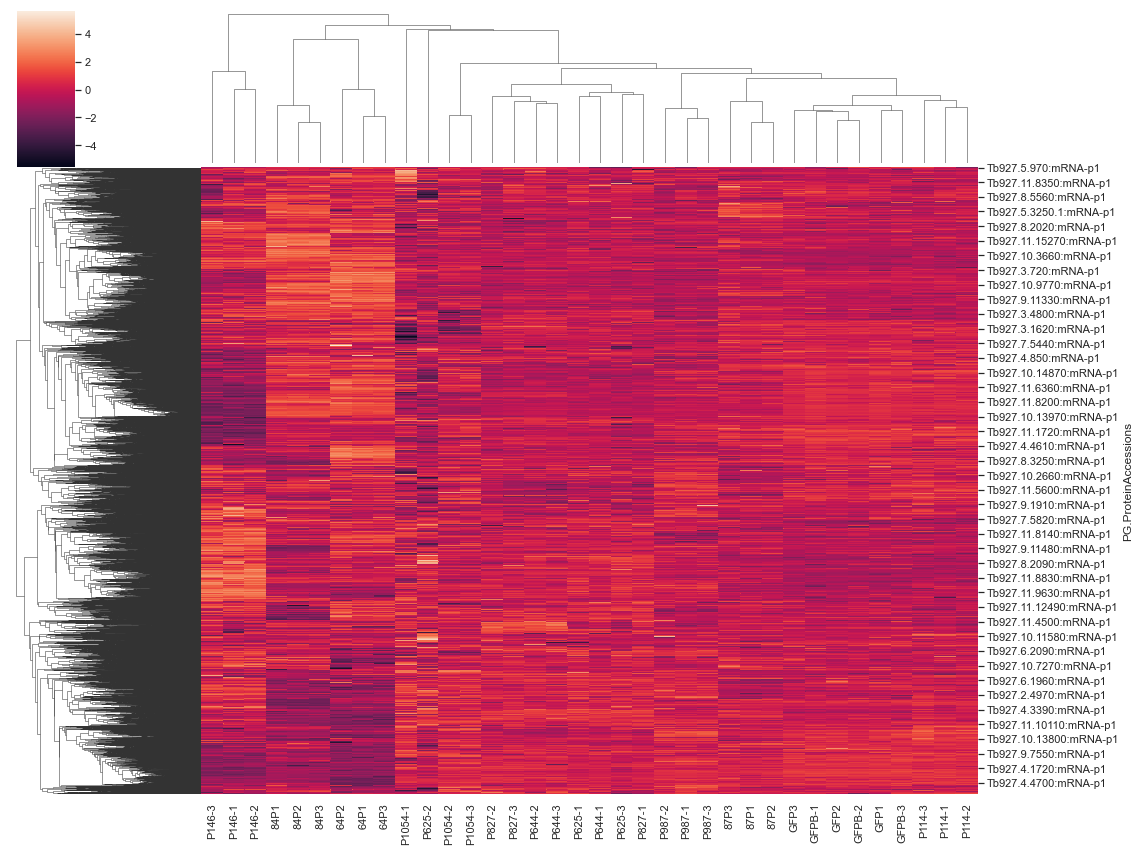

In [50]:
import seaborn as sns; sns.set_theme(color_codes=True)
sns.clustermap(temp,z_score=0,figsize=(16,12))

# Subset x Paper

## Before Batch effect

In [51]:
cols = ([n for n in selection_normed_rb if 'GFP' in n]+
        [n for n in selection_normed_rb if '64P' in n]+
        [n for n in selection_normed_rb if '84P' in n]+
        [n for n in selection_normed_rb if 'P146' in n])
        
        
        
ncols = []
for n in cols:
    if n not in ncols:
        ncols.append(n)

temp = selection_normed2[ncols]
temp.columns = (list(temp.columns[0:6])+
                ['MKT1-1','MKT1-2','MKT1-3']+
                ['PBP1-1','PBP1-2','PBP1-3']+
                ['CFB2-1','CFB2-2','CFB2-3'])

temp.head()

,GFP1,GFP2,GFP3,GFPB-1,GFPB-2,GFPB-3,MKT1-1,MKT1-2,MKT1-3,PBP1-1,PBP1-2,PBP1-3,CFB2-1,CFB2-2,CFB2-3
PG.ProteinAccessions,,,,,,,,,,,,,,,
GFP.BLA,1.423348e+06,1.682339e+06,1.652661e+06,2.665380e+06,2.821416e+06,2.641988e+06,8.370035e+05,8.601111e+05,8.129820e+05,8.937236e+05,8.852848e+05,8.937236e+05,6.884822e+05,8.007322e+05,5.726762e+05
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,1.522944e+05,1.569943e+05,1.894280e+05,2.813733e+05,2.557091e+05,2.506012e+05,1.543154e+05,1.783347e+05,1.535781e+05,1.379470e+05,1.588950e+05,1.626680e+05,2.245115e+05,2.576063e+05,2.160860e+05
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,2.200695e+06,2.688795e+06,2.561333e+06,1.599369e+06,1.555320e+06,1.771239e+06,1.914670e+06,2.163801e+06,2.255014e+06,2.297051e+06,2.456531e+06,2.460905e+06,1.543972e+06,1.539387e+06,1.705187e+06
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,3.228063e+05,3.210274e+05,3.377315e+05,3.604434e+05,3.677667e+05,3.705128e+05,2.457563e+05,2.521142e+05,2.773734e+05,2.569331e+05,2.521142e+05,2.587313e+05,2.400676e+05,2.045175e+05,3.439086e+05
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,3.694411e+06,3.332168e+06,3.863503e+06,2.002954e+06,1.947116e+06,1.561380e+06,2.395147e+06,1.895681e+06,2.536212e+06,2.753603e+06,2.748925e+06,2.753603e+06,9.871459e+05,1.219819e+06,1.165129e+06


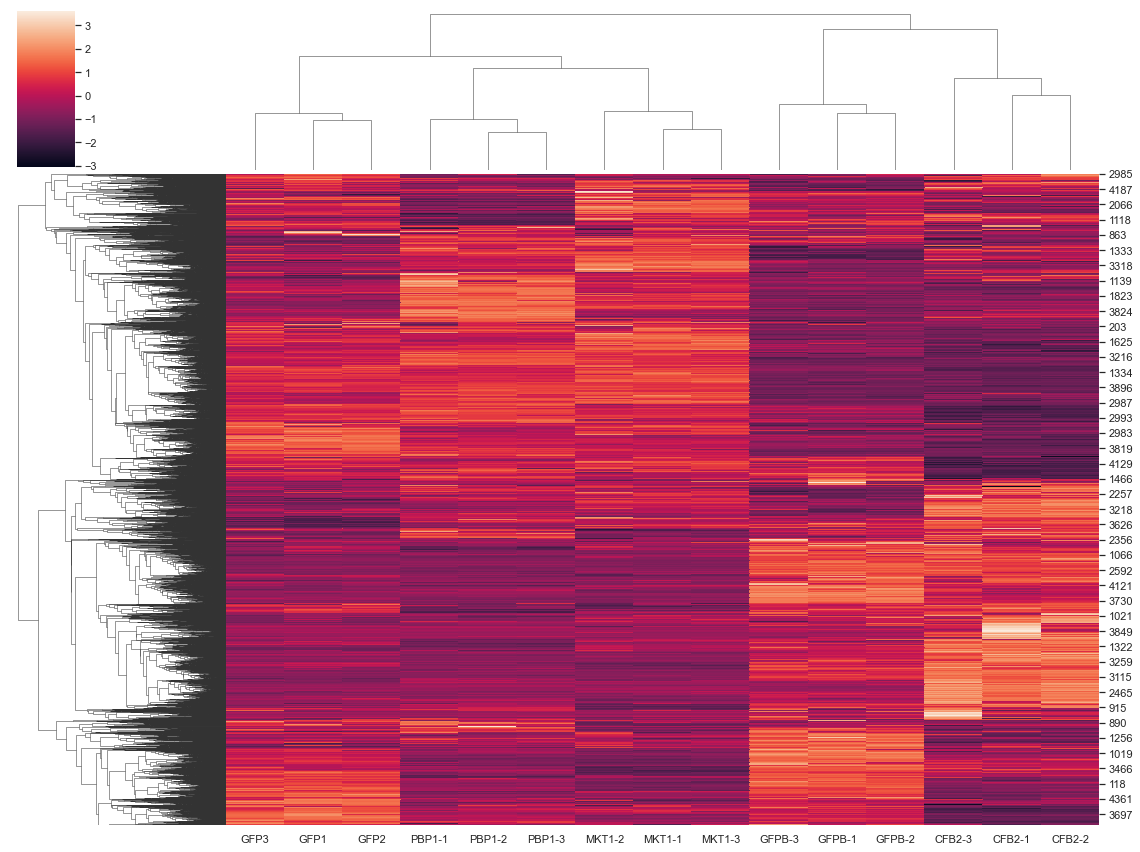

In [52]:
import seaborn as sns; sns.set_theme(color_codes=True)
sns.clustermap(temp.reset_index(drop=True),z_score=0,figsize=(16,12))

## After removing batch effect

In [53]:
#CFB2, MKT1 and PBP1

In [54]:
cols = ([n for n in selection_normed_rb if 'GFP' in n]+
        [n for n in selection_normed_rb if '64P' in n]+
        [n for n in selection_normed_rb if '84P' in n]+
        [n for n in selection_normed_rb if 'P146' in n])
        
        
        
ncols = []
for n in cols:
    if n not in ncols:
        ncols.append(n)

temp = selection_normed_rb[ncols]
temp.columns = (list(temp.columns[0:6])+
                ['MKT1-1','MKT1-2','MKT1-3']+
                ['PBP1-1','PBP1-2','PBP1-3']+
                ['CFB2-1','CFB2-2','CFB2-3'])

In [55]:
temp.shape[1]==(8*3)+3

False

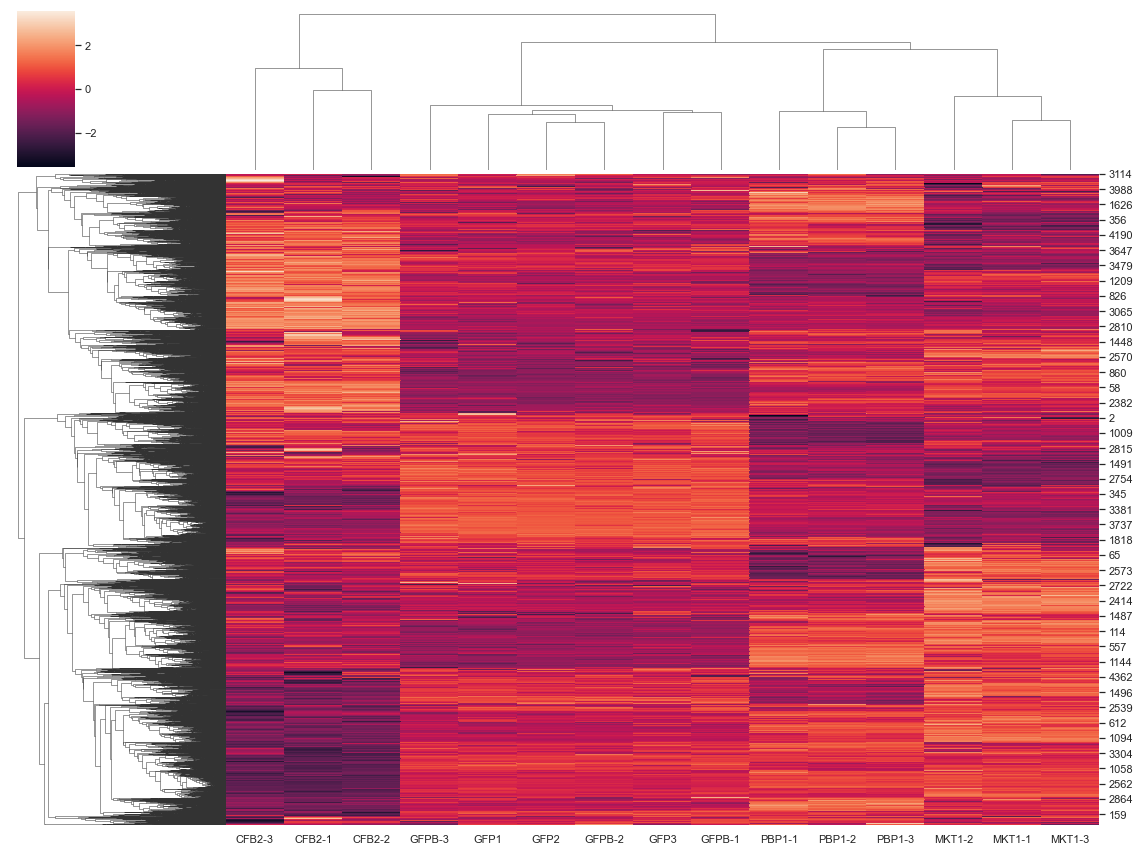

In [56]:
import seaborn as sns; sns.set_theme(color_codes=True)
sns.clustermap(temp.reset_index(drop=True),z_score=0,figsize=(16,12))

## Using only diff abundant genes

In [57]:
df_res1 = pd.read_csv('DIA_20210618/FinalDataset_batch1_927_MKT1.csv')
df_res2 = pd.read_csv('DIA_20210618/FinalDataset_batch1_927_PBP1.csv')
df_res3 = pd.read_csv('RBPs 2nd batch 927/FinalDataset_batch2_927_CFB2.csv')

In [58]:
#df_res3.head()

In [59]:
FDR_threshold=0.01
Log_fold_threshold = 1
genes_1 = df_res1[
    ((df_res1['P64-M64_adj.P.Val']<FDR_threshold) & 
     ((df_res1['P64-M64_logFC']<-Log_fold_threshold) | (df_res1['P64-M64_logFC']>Log_fold_threshold)))   

]['PG.ProteinAccessions']

genes_2 = df_res2[
    ((df_res2['P84-M84_adj.P.Val']<FDR_threshold) & 
     ((df_res2['P84-M84_logFC']<-Log_fold_threshold) | (df_res2['P84-M84_logFC']>Log_fold_threshold)))   

]['PG.ProteinAccessions']


genes_3 = df_res3[
    ((df_res3['P146-M146_P.Value']<FDR_threshold) & 
     ((df_res3['P146-M146_logFC']<-Log_fold_threshold) | (df_res3['P146-M146_logFC']>Log_fold_threshold))) 
     
]['PG.ProteinAccessions']




In [60]:
genes_all = list(set(list(genes_1)+list(genes_2)+list(genes_3)))
len(genes_all)

583

In [61]:
print(1)

1


In [62]:
genes_all2 = [n for n in genes_all if n in list(temp.index.values)]
len(genes_all2)

466

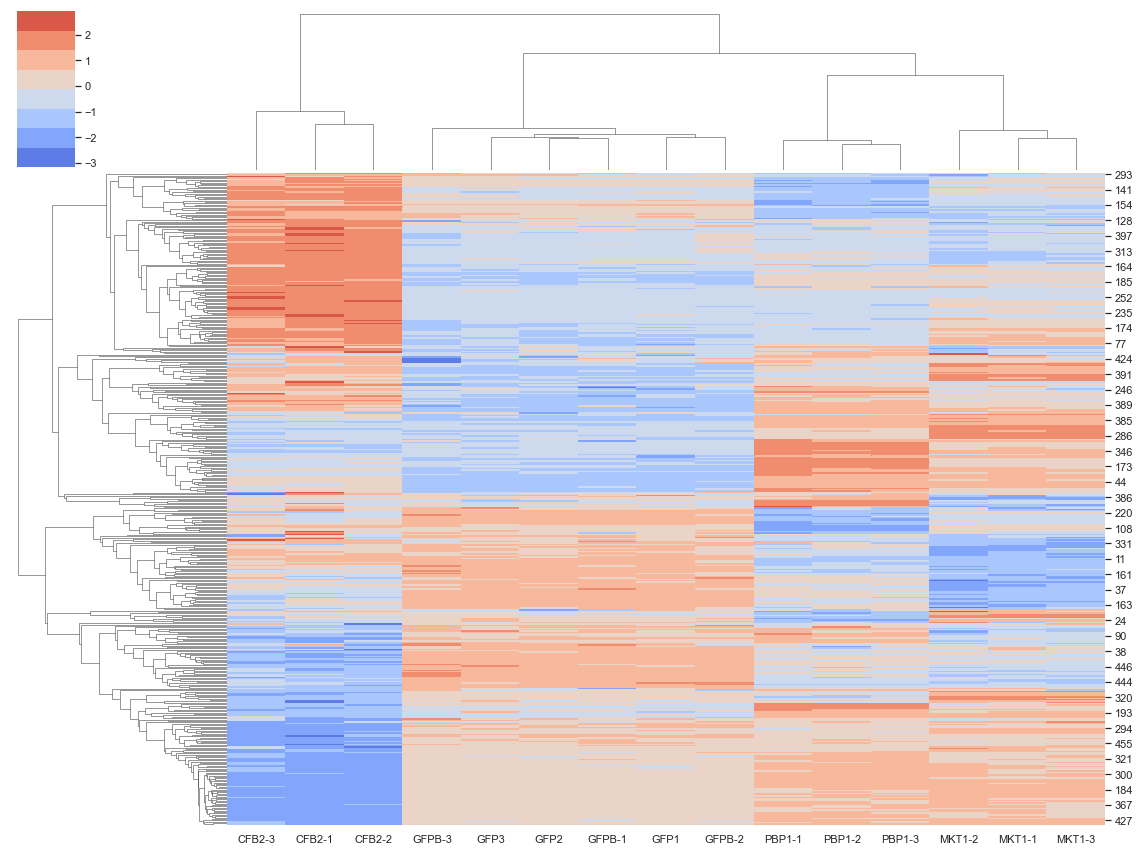

In [63]:
import seaborn as sns; sns.set_theme(color_codes=True)
sns.clustermap(temp.loc[genes_all2].reset_index(drop=True),
               cmap=sns.color_palette("coolwarm", 8),
               z_score=0,figsize=(16,12))

In [64]:
#temp.loc[genes_all2]
print(temp.shape)
temp.to_csv('selection_batches.csv')
temp.head()

(4402, 15)


,GFP1,GFP2,GFP3,GFPB-1,GFPB-2,GFPB-3,MKT1-1,MKT1-2,MKT1-3,PBP1-1,PBP1-2,PBP1-3,CFB2-1,CFB2-2,CFB2-3
PG.ProteinAccessions,,,,,,,,,,,,,,,
GFP.BLA,20.818838,21.057827,21.057851,20.966447,21.017254,20.950815,20.099413,20.182255,20.067312,20.162191,20.134014,20.141597,18.984715,19.175076,18.696515
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,17.503230,17.544722,17.855818,17.741487,17.577456,17.584828,17.522347,17.674924,17.480303,17.418375,17.640370,17.675226,17.433053,17.629070,17.360511
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,20.769943,21.057322,20.958784,20.910270,20.850711,21.025068,20.651978,20.885097,20.911848,20.844632,20.911804,20.906805,20.869444,20.892341,21.014477
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,18.369850,18.354943,18.448719,18.364306,18.396354,18.412852,17.961046,17.950173,18.181925,18.059687,18.062047,18.102548,17.800677,17.575792,18.302944
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,21.293629,21.183931,21.349175,21.438776,21.355250,21.032709,20.838580,20.530367,20.941874,20.899942,20.891197,20.883993,20.395665,20.728774,20.679863


In [65]:
!jupyter nbconvert --to html_toc merge_datasets-Copy1.ipynb

[NbConvertApp] WARNING | pattern 'merge_datasets-Copy1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to 